In [50]:
import torch
from torch import nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
print("pyTorch ver : ", torch.__version__)

pyTorch ver :  1.12.1+cu116


In [51]:
!nvidia-smi

Wed Oct  5 11:20:30 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 517.48       Driver Version: 517.48       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   60C    P0    27W /  N/A |   1700MiB /  6144MiB |      4%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [52]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [53]:
n_samples = 20000

x, y = make_circles(n_samples, noise=0.02, random_state=47)

(x[:7], y[:7])

(array([[ 0.78681061,  0.26754685],
        [ 0.77330068, -0.621825  ],
        [ 0.73564799, -0.36315775],
        [-0.98866113,  0.0144999 ],
        [-0.53229971, -0.82148342],
        [ 0.90394199, -0.36077276],
        [-0.82840402, -0.58662951]]),
 array([1, 0, 1, 0, 0, 0, 0], dtype=int64))

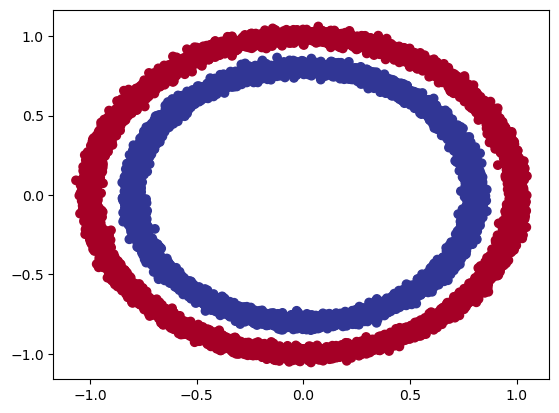

In [54]:
plt.scatter(
  x=x[:, 0],
  y=x[:, 1],
  c=y,
  cmap=plt.cm.RdYlBu
)

In [55]:
x = torch.from_numpy(x).type(torch.float).to(device)
y = torch.from_numpy(y).type(torch.float).to(device)

x, y

(tensor([[ 0.7868,  0.2675],
         [ 0.7733, -0.6218],
         [ 0.7356, -0.3632],
         ...,
         [-0.8162,  0.2031],
         [ 0.4344, -0.7192],
         [-0.9836, -0.1503]], device='cuda:0'),
 tensor([1., 0., 1.,  ..., 1., 1., 0.], device='cuda:0'))

In [56]:
x_train, x_test, y_train, y_test = train_test_split(
  x,
  y,
  test_size=0.2, # 20%
  random_state=74
)

x_train, x_test, y_train, y_test

(tensor([[ 0.8853, -0.4303],
         [-0.9976,  0.0148],
         [ 0.7934, -0.0600],
         ...,
         [ 0.3865,  0.6790],
         [-0.7516,  0.2998],
         [-0.9673,  0.2606]], device='cuda:0'),
 tensor([[-0.5829,  0.7839],
         [-0.6009, -0.5301],
         [-0.0888,  0.9974],
         ...,
         [ 0.9775,  0.0833],
         [ 0.0201,  0.9798],
         [ 1.0285,  0.0515]], device='cuda:0'),
 tensor([0., 0., 1.,  ..., 1., 1., 0.], device='cuda:0'),
 tensor([0., 1., 0.,  ..., 0., 0., 0.], device='cuda:0'))

In [57]:
device

'cuda'

In [58]:
class CircleModle(nn.Module):
  def __init__(self):
    super().__init__()

    self.l1 = nn.Linear(in_features=2, out_features=16)
    self.l2 = nn.Linear(in_features=16, out_features=8)
    self.l3 = nn.Linear(in_features=8, out_features=1)
    self.relu = nn.ReLU()
  
  def forward(self, x):
    return self.l3(
      self.relu(
        self.l2(
          self.relu(
            self.l1(x)
          )
        )
      )
    )

CircleModle

__main__.CircleModle

In [59]:
model = CircleModle().to(device)

model, next(model.parameters()).device

(CircleModle(
   (l1): Linear(in_features=2, out_features=16, bias=True)
   (l2): Linear(in_features=16, out_features=8, bias=True)
   (l3): Linear(in_features=8, out_features=1, bias=True)
   (relu): ReLU()
 ),
 device(type='cuda', index=0))

In [60]:
# Setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), 
                            lr=0.1)

In [61]:
# Calculate accuracy - out of 100 examples, what percentage does our model get right? 
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item() 
  acc = (correct/len(y_pred)) * 100
  return acc

In [62]:
# Random Seeds
torch.manual_seed(74)
torch.cuda.manual_seed(74)

# epochs
epochs = 10000

for epoch in range(epochs):
  ## training
  model.train()

  # 1> Forward pass
  y_logits = model(x_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  # calculate loss
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)
  
  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward
  loss.backward()

  # 5. Step the optimizer
  optimizer.step()

  ### Testing
  model.eval()
  with torch.inference_mode():
    test_logits = model(x_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
    
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test, 
                           y_pred=test_pred)
  
  # Print out what's this happenin'
  if epoch % 1000 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.4f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.6998, Acc: 50.07% | Test Loss: 0.7003, Test Acc: 49.73%
Epoch: 1000 | Loss: 0.6670, Acc: 65.89% | Test Loss: 0.6669, Test Acc: 65.55%
Epoch: 2000 | Loss: 0.0315, Acc: 100.00% | Test Loss: 0.0314, Test Acc: 100.00%
Epoch: 3000 | Loss: 0.0065, Acc: 100.00% | Test Loss: 0.0068, Test Acc: 100.00%
Epoch: 4000 | Loss: 0.0033, Acc: 100.00% | Test Loss: 0.0036, Test Acc: 100.00%
Epoch: 5000 | Loss: 0.0022, Acc: 100.00% | Test Loss: 0.0024, Test Acc: 100.00%
Epoch: 6000 | Loss: 0.0016, Acc: 100.00% | Test Loss: 0.0018, Test Acc: 100.00%
Epoch: 7000 | Loss: 0.0013, Acc: 100.00% | Test Loss: 0.0015, Test Acc: 100.00%
Epoch: 8000 | Loss: 0.0010, Acc: 100.00% | Test Loss: 0.0012, Test Acc: 100.00%
Epoch: 9000 | Loss: 0.0009, Acc: 100.00% | Test Loss: 0.0010, Test Acc: 100.00%


In [63]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if it's not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


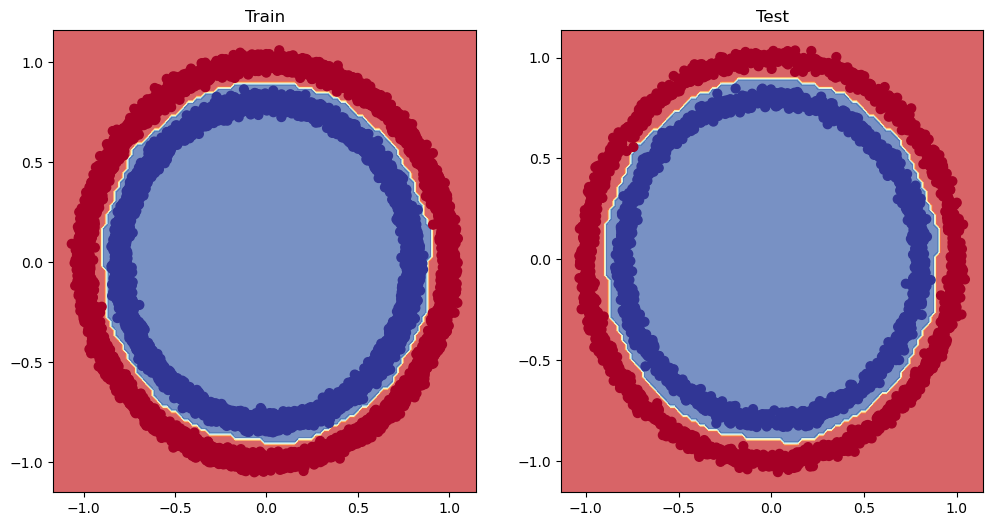

In [64]:
# Plot decision boundaries
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, x_train, y_train) # model_1 = no non-linearity
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, x_test, y_test) # model_3 = has non-linearity